# <u><center>PROJET : Escape no game<center></u>

### GP1.4<br>
- Fabien Arrighi<br>
- Malaury Brown<br>
- Arnaud Caci

## <u>Livrable 4 :</u> Modélisation numérique - traitement informatique du signal

### <u>Contexte</u>
Maintenant que la chaîne transmission a été réalisé, nous passons à présent à l'élaboration d'un prototype à l'aide du langage de programmation Python.

### <u>Code</u>
Notre code va être divisé en deux partie, la première représentera le traitement réalisé dans le Pad de l'agent (phase aller) et la deuxième sera le traitement réalisé par l'ordinateur de l'agent à l'écoute (phase retour). Pour représenter le canal de transmission, les données du signal modulé sont enregistré dans un fichier .csv pour être récupérer par la deuxième partie du programme et pouvoir récupérer le message transmit.

#### <u>Code phase aller</u>
Commençons par la première partie qui correspond à ce morceau de notre chaîne de transmission :
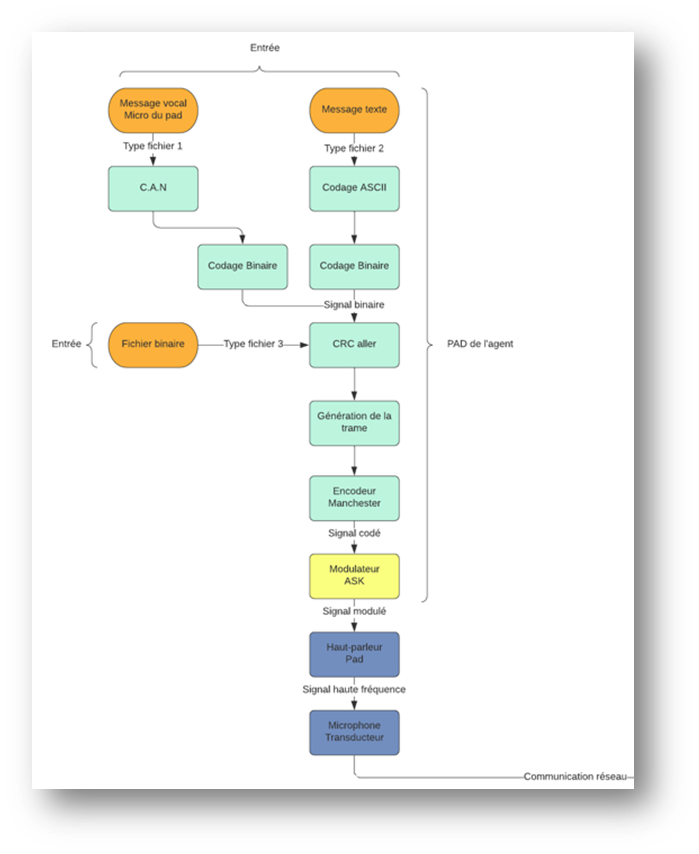
Des différences notables entre la chaîne de transmission et notre programme existe tel que la transmission de message vocal qui n'est pas présente dans le programme ainsi que l'émission de haute fréquence par le haut-parleur du Pad et la reception par le micro de la salle de conférence. Tout cela est remplacé par la création automatique d'un fichier pour stocker les valeurs du signal modulé qui sera ensuite utilisé pour la deuxième partie du programme.

Nous commençons par appeler les modules qui nous seront nécessaire pour la suite du programme

In [1]:
import matplotlib.pyplot as plt
import numpy as np

La fonction crcAller() permet de réaliser une division pour calculer le reste à ajouter à la fin de chaque octet de données à envoyer.

In [2]:
def crcAller(bits):
    diviseur = "1001"   #Diviseur pour notre protocole crc (diviseur commun à l'envoyeur et le recepteur)
    resultat_crc = []   #Liste pour stocker les données en ajoutant le reste de la division euclidienne

    for e in range(0, len(bits)//8):  #On parcours chaque octet de données
        donne_str = ""
        for i in bits[0:8]:     #On découpe nos données par paquet de 8 bits
            donne_str = donne_str + str(i)
            del bits[0]

        donne_str_dividende = donne_str + "0000"
        donne_int_dividende = int("0B" + donne_str_dividende,0) #Converti le dividende en décimal
        diviseur_dec = int("0B" + diviseur,0)   #Converti le diviseur en décimal
        reste = donne_int_dividende % diviseur_dec  #Récupère le reste de la division
        reste_bin = bin(reste)[2:].zfill(4)  #Le reste est en binaire et doit faire obligatoirement 4 bits (exemple : 0010; 1101; 0111...)
        donnee_int = bin(int("0B" + donne_str,0))[2:].zfill(8)

        for j in donnee_int:     #Ajoute les données dans une liste
            if j == "1":
                resultat_crc.append(1)
            if j == "0":
                resultat_crc.append(0) 
        for k in reste_bin:      #Ajoute le reste à la fin de l'octet
            if k == "1":
                resultat_crc.append(1)
            if k == "0":
                resultat_crc.append(0)

    print("resultat crc", resultat_crc) #Affiche les données une fois traité par le protocole crc
    return resultat_crc #Retourne les données une fois traité par le protocole crc

La fonction trame() ajoute tout les octets nécessaire pour la constitution de la trame de données à envoyer.

In [3]:
def trame(bits, type_fichier):
    #Octet pour définir le type de fichier envoyé, chaque type de fichier à un octet différent
    prot_txt = [1,1,0,0,0,0,1,1]
    prot_txt2 = [1,1,0,1,1,0,1,1]
    prot_bin = [0,1,1,0,0,1,1,0]

    if type_fichier == "txt":   #Si le type de fichier envoyé est un message on ajoute l'octet correspondant à ce type de fichier
        bits = prot_txt + bits
        print("Octet protocole type de fichier : ", prot_txt) #On affiche l'octet ajouté
    elif type_fichier == "txt2":
        bits = prot_txt2 + bits
        print("Octet protocole type de fichier : ", prot_txt2)
    elif type_fichier == "bin":
        bits = prot_bin + bits
        print("Octet protocole type de fichier : ", prot_bin)

    #Fanion
    fanion_debut = [1,1,1,1,1,1,1,1]    #Octet représentant le début de la trame
    fanion_fin = [0,0,0,0,0,0,0,0]  #Octet représentant la fin de la trame
    bits = fanion_debut + bits
    print("Fanion de début : ", fanion_debut)
    bits = bits + fanion_fin
    print("Fanion de fin : ", fanion_fin)
    print("Trame", bits)
    return bits #On retourne la trame entière

Fonction réalisant le codage Manchester

In [4]:
def Manchester(bits):
    manchester = [] #Liste pour stocker le résultat du codage Manchester
    for i in list(bits): #On parcour la liste bits
        if i == 1:  #Si 1 est dans la liste bits, on ajoute 1 et 0 dans une autre liste
            manchester.append(1)
            manchester.append(0)
        if i == 0:  #Si 0 est dans la liste bits, on ajoute 1 et 0 dans une autre liste
            manchester.append(0)
            manchester.append(1)

    print("Codage Manchester : ", manchester) #On affiche le résultat du codage Manchester
    return manchester   #On retourne le résultat du codage Manchester

Modulation de notre trame de données codé en Manchester

In [5]:
def ASK(ASK_manchester):

    Fe = 44100                            # Fréquence d'échantillonnage
    baud = 200                            # Débit souhaité sur le canal de transmission exprimé en bit/s
    Nbits = len(ASK_manchester)           # Nombre de bits à transmettre
    Ns = int(Fe/baud)                     # Nombre de symboles par bit (Fréq d'echan / Débit binaire)
    N = int(Nbits * Ns)                   # Nombre de symboles total à envoyer (Nombre de symboles par bit * Nombre de bits)
    Fp = 2000                             # Fréquence de l'onde porteuse (2000 Hz)

    # Le message binaire initial est dupliqué Ns fois pour avoir un vecteur de même taille que le temps (t)
    message_bit_duplique= np.repeat(ASK_manchester, Ns)

    t = np.arange (0.0, N) / Fe

    # On rélalise la modulation en amplitude
    Porteuse = np.sin(2 * np.pi * Fp * t)

    ASK = message_bit_duplique * Porteuse

    # Enregitrer dans un ficheir CSV le résulats de la modulation ASK
    np.savetxt("Message.csv", ASK, fmt='%.6f', delimiter=',')

    print("Signal modulé : ", ASK) #On affiche le signal modulé

    plt.figure (figsize = (10,6))   #On définitla taille des graph
    plt.plot(t[0:2000],message_bit_duplique[0:2000])    #On affiche qu'une partie des échantillons (pour que cela soit lisible)
    plt.xlabel("Temps [s]")
    plt.title("Message binaire codé Manchester")

    plt.figure (figsize = (10,6))
    plt.plot(t[0:2000],Porteuse[0:2000])
    plt.title("Porteuse")

    plt.figure (figsize = (10,6))
    plt.plot(t[0:2000],ASK[0:2000])
    plt.xlabel("Temps [s]")
    plt.title("Modulation ASK (amplitude) du message binaire codé Manchester")

    plt.show()  #On affiche les graph

Fonction définissant les actions à réaliser si l'on souhaite envoyer un message ou un fichier texte.

In [6]:
def message():
    texte = ""  #Initialisation des variables
    texte_bit = []

    reponse = int(input("""Quel type de message envoyer ? 
    Message -> 1 
    Fichier texte -> 2\n"""))
    print("Réponse sélectionnée : ", reponse)   #Affiche la réponse sélectionné

    if reponse == 1:
        type_fichier = "txt"    #Donne le type de fichier qui va être envoyé pour la composition de la trame
        while(len(texte) == 0): #Tant que le message que l'on souhaite envoyer est vide, on affiche le message suivant
            texte = input("Saisissez votre message\n")

    elif reponse == 2:
        fichier = ""
        type_fichier = "txt2"
        while(len(fichier) == 0):
            try :
                fichier = input("Entrez le nom du fichier (sans l'extension)\n")    #Demande la saisie du nom du fichier à envoyer
                searchfile = open(fichier + ".txt", "r")    #Ouvre le fichier demandé en lecture
                for i in searchfile:    #Parcours le fichier
                    texte = i   #Récupère les caractères dans le fichier
                searchfile.close()  #Ferme le fichier
                print(texte)    #Affiche le texte dans le fichier
            except FileNotFoundError:   #Si le fichier est introuvable ou n'existe pas cela est signalé et on attend la saisi d'un nom de fichier correct
                print("Fichier introuvable. Veuillez réessayer")
                fichier = ""

    for char in texte:  #Parcour le texte à envoyer pour le convertir en ASCII
        if len(bin(ord(char))[2:]) == 7:    #Si le caractère est codé sur 7 bits (table ASCII de base)
            binaire = "0" + bin(ord(char))[2:]  #On ajoute un 0 au début et on converti le code unique ASCII du caractère en binaire ([2:] permet d'enlever les deux premier caractère de la valeur binaire soit 0b)
        elif len(bin(ord(char))[2:]) == 6:  #Si le caractère est codé sur 6 bits tel que le caractère espace
            binaire = "00" + bin(ord(char))[2:] #On ajoute deux 0 au débutau début et on converti le code unique ASCII du caractère en binaire
        else:   #Si le caractère ASCII est déjà sur 8 bits (table ASCII étendue)
            binaire = bin(ord(char))[2:]
        texte_bit.extend(int(i) for i in binaire)   #On ajoute tout les bits dans une liste (après avoir converti les élément en int)

    print("Texte en binaire : ", texte_bit) #On affiche notre texte codé en binaire
    
    texte_bit_crc = crcAller(texte_bit)     #Phase aller du protocole CRC
    trame_bin = trame(texte_bit_crc, type_fichier)  #Création de la trame de données
    texte_bit_Manchester = Manchester(trame_bin)    #On encode le signal
    ASK(texte_bit_Manchester)   #On module le signal

Fonction définissant les actions à réaliser si l'on souhaite envoyer un fichier binaire.

In [7]:
def binaire():
    fichier = ""
    list_bin = []
    type_fichier = "bin"
    while(len(fichier) == 0):   #Tant que le aucun nom de fichier est saisi
        try :
            fichier = input("Entrez le nom du fichier (sans l'extension)\n")    #Demande la saisie du nom du fichier à envoyer
            searchfile = open(fichier + ".txt", "r")    #Ouvre le fichier en lecture
            for i in searchfile:    #Parcours le fichier et récupère la suite binaire entière
                for e in i: #Parcours chaque élément
                    list_bin.append(int(e)) #Ajoute chaque élément à une liste
            searchfile.close()  #Fermeture du fichier
        except FileNotFoundError:   #Si le fichier est introuvable ou n'existe pas cela est signalé et on attend la saisi d'un nom de fichier correct
            print("Fichier introuvable. Veuillez réessayer")
            fichier = ""

    print("Message binaire : ", list_bin)   #Affiche la suite binaire qui va être envoyer

    texte_bit_crc = crcAller(list_bin)
    trame_bin = trame(texte_bit_crc, type_fichier)
    texte_bit_Manchester = Manchester(trame_bin)
    ASK(texte_bit_Manchester)

Partie du code qui s'exécute au lancement du programme pour choisir le message à envoyer.

                                                                                    
░█▀▀░█▀▄░█▀█░█░█░█▀█░█▀▀   ▄█░ ░ ░█▀█░ 
░█░█░█▀▄░█░█░█░█░█▀▀░█▀▀   ░█░ ▄ █▄▄█▄ 
░▀▀▀░▀░▀░▀▀▀░▀▀▀░▀░░░▀▀▀   ▄█▄ █ ░░░█░

███████╗███████╗ ██████╗ █████╗ ██████╗ ███████╗    ███╗   ██╗ ██████╗      ██████╗  █████╗ ███╗   ███╗███████╗
██╔════╝██╔════╝██╔════╝██╔══██╗██╔══██╗██╔════╝    ████╗  ██║██╔═══██╗    ██╔════╝ ██╔══██╗████╗ ████║██╔════╝
█████╗  ███████╗██║     ███████║██████╔╝█████╗      ██╔██╗ ██║██║   ██║    ██║  ███╗███████║██╔████╔██║█████╗  
██╔══╝  ╚════██║██║     ██╔══██║██╔═══╝ ██╔══╝      ██║╚██╗██║██║   ██║    ██║   ██║██╔══██║██║╚██╔╝██║██╔══╝  
███████╗███████║╚██████╗██║  ██║██║     ███████╗    ██║ ╚████║╚██████╔╝    ╚██████╔╝██║  ██║██║ ╚═╝ ██║███████╗
╚══════╝╚══════╝ ╚═════╝╚═╝  ╚═╝╚═╝     ╚══════╝    ╚═╝  ╚═══╝ ╚═════╝      ╚═════╝ ╚═╝  ╚═╝╚═╝     ╚═╝╚══════╝

Quel type de message souhaitez-vous envoyer ?
    Message écrit -> 1
    Fichier binaire -> 2
1
Réponse sélectionnée :  1


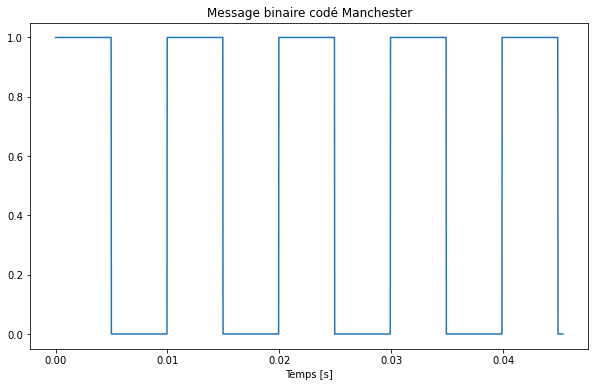

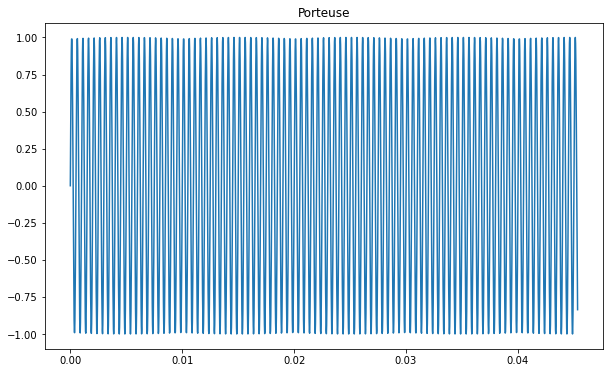

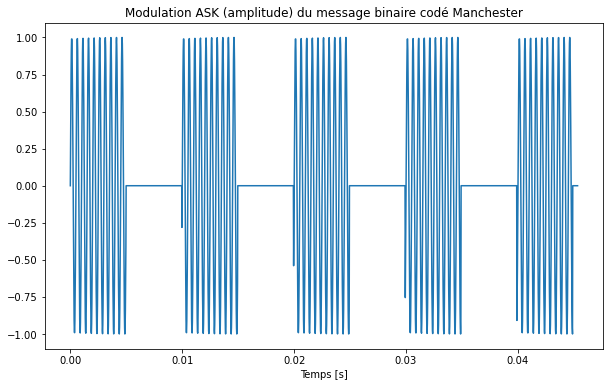

In [8]:
print("""                                                                                    
░█▀▀░█▀▄░█▀█░█░█░█▀█░█▀▀   ▄█░ ░ ░█▀█░ 
░█░█░█▀▄░█░█░█░█░█▀▀░█▀▀   ░█░ ▄ █▄▄█▄ 
░▀▀▀░▀░▀░▀▀▀░▀▀▀░▀░░░▀▀▀   ▄█▄ █ ░░░█░

███████╗███████╗ ██████╗ █████╗ ██████╗ ███████╗    ███╗   ██╗ ██████╗      ██████╗  █████╗ ███╗   ███╗███████╗
██╔════╝██╔════╝██╔════╝██╔══██╗██╔══██╗██╔════╝    ████╗  ██║██╔═══██╗    ██╔════╝ ██╔══██╗████╗ ████║██╔════╝
█████╗  ███████╗██║     ███████║██████╔╝█████╗      ██╔██╗ ██║██║   ██║    ██║  ███╗███████║██╔████╔██║█████╗  
██╔══╝  ╚════██║██║     ██╔══██║██╔═══╝ ██╔══╝      ██║╚██╗██║██║   ██║    ██║   ██║██╔══██║██║╚██╔╝██║██╔══╝  
███████╗███████║╚██████╗██║  ██║██║     ███████╗    ██║ ╚████║╚██████╔╝    ╚██████╔╝██║  ██║██║ ╚═╝ ██║███████╗
╚══════╝╚══════╝ ╚═════╝╚═╝  ╚═╝╚═╝     ╚══════╝    ╚═╝  ╚═══╝ ╚═════╝      ╚═════╝ ╚═╝  ╚═╝╚═╝     ╚═╝╚══════╝

Quel type de message souhaitez-vous envoyer ?
    Message écrit -> 1
    Fichier binaire -> 2""")

suivant = 0

while suivant == 0:
    try:
        reponse = int(input())
        print("Réponse sélectionnée : ", reponse)
        suivant = 1
    except ValueError:
        print("Veuillez sélectionner une réponse valide")

if reponse == 1 :
    message() 
elif reponse == 2 :
    binaire()
else :
    print("Réponse invalide")

#### <u>Code phase retour</u>
Nous passons à la deuxième partie du programme qui a pour but de récupérer le signal envoyer pour récupérer le message transmit

Appel des modules qui nous seront nécessaire pour la suite du programme

In [9]:
import numpy as np
import os

Démodulation du signal reçu

In [10]:
def ASK():
    #Lecture Fichier CSV
    ASK1 = np.genfromtxt("Message.csv")
    print("Signal modulé : ", ASK1)

    N = len(ASK1)
    Ns = 220
    Fe = 44100
    Fp = 2000

    t = np.arange (0.0,N)/Fe    #Vecteur temps

    Porteuse=np.sin(2 * np.pi * Fp * t) # Porteuse
    Produit = ASK1 * Porteuse   # Multiplier le signal modulé par le signal de la porteuse utilisée

    y = []

    for i in range(0, N, Ns):
        y.append (np.trapz(Produit[i:i+Ns], t[i:i+Ns]))

    message_demodule = np.array(y) > 0 

    message_recu_decode = []

    for ii in range (0, len(message_demodule)):
        
        if message_demodule [ii] == True:
            message_recu_decode.extend([int(1)]) 
        else:
            message_recu_decode.extend([int(0)]) 
    print("Signal démodulé : ", message_recu_decode)
    return(message_recu_decode)

Décodage Manchester

In [11]:
def Manchester(bits):
    manchester = [] #Liste pour stocker le résultat du codage Manchester
    for i in range(0,round(len(bits)/2)):   #Parcours la suite binaire reçue
        if (bits[2*i] == 1 and bits[2*i+1] == 0):   #Parcours les éléments deux par deux
            manchester.append(1)    #Si on a 1 et 0 à la suite, on ajoute 1 dans une autre liste
        if (bits[2*i] == 0 and bits[2*i+1] == 1):
            manchester.append(0)    #Si on a 0 et 1 à la suite, on ajoute 0 dans une autre liste
    print("Décodage Manchester : ", manchester)   #On affiche les données une fois décodé
    return manchester

Vérification de la trame de données reçue

In [12]:
def trame(bits):
    fanion_debut = []
    fanion_fin = []
    type_fichier = ""

    for i in bits[0:8]:     #Vérification du premier octet
       fanion_debut.append(i) 
       del bits[0]
    print("Fanion de début : ", fanion_debut)
    for i in bits[-8:]:     #Vérification du dernier octet
        fanion_fin.append(i) 
        del bits[-1]
    print("Fanion de fin : ", fanion_fin)
    if fanion_debut == [1,1,1,1,1,1,1,1] and fanion_fin == [0,0,0,0,0,0,0,0]:   #Si les fanion de début et de fin sont correct
        print("Début de transmission")
        protocole = []
        for i in bits[0:8]:     #On vérifie l'octet de protocole
            protocole.append(i) 
            del bits[0]
        print("Type de message", protocole)
        if protocole == [1,1,0,0,0,0,1,1]:  #Identification du protocole envoyé
            print("Nouveau message reçu")
            print("Données", bits)
            type_fichier = "txt"    #Enregistre le type de fichier reçu
            return bits, type_fichier
        elif protocole == [1,1,0,1,1,0,1,1]:
            print("Nouveau fichier texte reçu")
            print("Données", bits)
            type_fichier = "txt2"
            return bits, type_fichier
        elif protocole == [0,1,1,0,0,1,1,0]:
            print("Nouveau fichier binaire reçu")
            print("Données", bits)
            type_fichier = "bin"
            return bits, type_fichier 
        else:
            print("Erreur protocole inconnu")
    else:
        print("Erreur fanion manquant dans la trame de données transmise")

Vérification de l'intégrité des données reçue

In [13]:
def crcRetour(bits):
    diviseur = "1001"   #Diviseur pour notre protocole crc (diviseur commun à l'envoyeur et le recepteur)
    resultat_crc = []   #Liste pour stocker les données une fois le reste enlevé et les données vérifié
    integrite_donnee = True

    for e in range(0, len(bits)//12):  #On parcours chaque octet de données plus le reste ajouté
        donne_str = ""
        for i in bits[0:12]:    #On découpe nos données par paquet de 8 bits (octet de données + 4 bits de reste)
            donne_str = donne_str + str(i)
            del bits[0]

        reste_reçu = donne_str[8:]      #On isole l'octet de donnée reçu du reste ajouté dans la phase aller du CRC
        donne_str2 = donne_str[:-4]
        donne_str_dividende = donne_str2 + "0000"
        donne_int_dividende = int("0B" + donne_str_dividende,0) #Converti le dividende en décimal
        diviseur_dec = int("0B" + diviseur,0)   #Converti le diviseur en décimal
        reste = donne_int_dividende % diviseur_dec  #Récupère le reste de la division
        reste_bin = bin(reste)[2:].zfill(4)     #Le reste est en binaire et doit faire obligatoirement 4 bits (exemple : 0010; 1101; 0111...)
        donnee_int = bin(int("0B" + donne_str,0))[2:-4].zfill(8)

        for j in donnee_int: #Ajoute les données dans une liste
            if j == "1":
                resultat_crc.append(1)
            if j == "0":
                resultat_crc.append(0) 
        if reste_reçu == reste_bin: #Vérifie si le reste obtenu correspond au reste reçu
            integrite_donnee = True
        if reste_reçu != reste_bin:
            integrite_donnee = False
    if integrite_donnee:
        print("Aucune erreur de transmission détectée")
        print("Résultat crc", resultat_crc)
        return resultat_crc
    else:
        print("Erreur lors de la transmission des données")

Si le message reçu est un texte, les données sont converties en caractère à l'aide de la table ASCII étendue

In [14]:
def ASCII(bits, type_fichier):
    bin_data = ""
    for elem in bits:  
        bin_data += str(elem)

    data_reçu =""  #Initialisation d'une chaîne vide pour stocker les données reçues

    def BinaryToDecimal(binary):  
        decimal, i = 0, 0   #Initialisation des variables

        while(binary != 0): 
            dec = binary % 10
            decimal = decimal + dec * pow(2, i) 
            binary = binary//10
            i += 1
        return (decimal)

    for i in range(0, len(bin_data), 8): 
        temp_data = int(bin_data[i:i+8])
        decimal_data = BinaryToDecimal(temp_data)
        data_reçu = data_reçu + chr(decimal_data) 

    if type_fichier == "txt":
        print("Le message reçu est :", data_reçu) 
    if type_fichier == "txt2":
        return data_reçu

In [15]:
def creationFichier(bits):
    fichier_bin = open("message_recu.txt","w")  #Création d'un fichier vide
    bin_data = ""   
    for elem in bits:  
        bin_data += str(elem)
    fichier_bin.write(bin_data)
    fichier_bin.close()
    print("Fichier enregistré")
    os.startfile("message_recu.txt")

Code affichant le message reçu

In [16]:
print("""                                                                                    
░█▀▀░█▀▄░█▀█░█░█░█▀█░█▀▀   ▄█░ ░ ░█▀█░ 
░█░█░█▀▄░█░█░█░█░█▀▀░█▀▀   ░█░ ▄ █▄▄█▄ 
░▀▀▀░▀░▀░▀▀▀░▀▀▀░▀░░░▀▀▀   ▄█▄ █ ░░░█░

███████╗███████╗ ██████╗ █████╗ ██████╗ ███████╗    ███╗   ██╗ ██████╗      ██████╗  █████╗ ███╗   ███╗███████╗
██╔════╝██╔════╝██╔════╝██╔══██╗██╔══██╗██╔════╝    ████╗  ██║██╔═══██╗    ██╔════╝ ██╔══██╗████╗ ████║██╔════╝
█████╗  ███████╗██║     ███████║██████╔╝█████╗      ██╔██╗ ██║██║   ██║    ██║  ███╗███████║██╔████╔██║█████╗  
██╔══╝  ╚════██║██║     ██╔══██║██╔═══╝ ██╔══╝      ██║╚██╗██║██║   ██║    ██║   ██║██╔══██║██║╚██╔╝██║██╔══╝  
███████╗███████║╚██████╗██║  ██║██║     ███████╗    ██║ ╚████║╚██████╔╝    ╚██████╔╝██║  ██║██║ ╚═╝ ██║███████╗
╚══════╝╚══════╝ ╚═════╝╚═╝  ╚═╝╚═╝     ╚══════╝    ╚═╝  ╚═══╝ ╚═════╝      ╚═════╝ ╚═╝  ╚═╝╚═╝     ╚═╝╚══════╝
""")

signal_reçu = ASK() #On démodule le signal
signal_decode = Manchester(signal_reçu) #On décode le signal
donnee, type_fichier = trame(signal_decode) #On vérifie la trame
signal_verif = crcRetour(donnee)    #On vérifie l'intégrité des données

if type_fichier == "txt":
    ASCII(signal_verif, type_fichier)
if type_fichier == "txt2":
    texte_ASCII = ASCII(signal_verif, type_fichier)
    creationFichier(texte_ASCII)
if type_fichier == "bin":
    creationFichier(signal_verif)

                                                                                    
░█▀▀░█▀▄░█▀█░█░█░█▀█░█▀▀   ▄█░ ░ ░█▀█░ 
░█░█░█▀▄░█░█░█░█░█▀▀░█▀▀   ░█░ ▄ █▄▄█▄ 
░▀▀▀░▀░▀░▀▀▀░▀▀▀░▀░░░▀▀▀   ▄█▄ █ ░░░█░

███████╗███████╗ ██████╗ █████╗ ██████╗ ███████╗    ███╗   ██╗ ██████╗      ██████╗  █████╗ ███╗   ███╗███████╗
██╔════╝██╔════╝██╔════╝██╔══██╗██╔══██╗██╔════╝    ████╗  ██║██╔═══██╗    ██╔════╝ ██╔══██╗████╗ ████║██╔════╝
█████╗  ███████╗██║     ███████║██████╔╝█████╗      ██╔██╗ ██║██║   ██║    ██║  ███╗███████║██╔████╔██║█████╗  
██╔══╝  ╚════██║██║     ██╔══██║██╔═══╝ ██╔══╝      ██║╚██╗██║██║   ██║    ██║   ██║██╔══██║██║╚██╔╝██║██╔══╝  
███████╗███████║╚██████╗██║  ██║██║     ███████╗    ██║ ╚████║╚██████╔╝    ╚██████╔╝██║  ██║██║ ╚═╝ ██║███████╗
╚══════╝╚══════╝ ╚═════╝╚═╝  ╚═╝╚═╝     ╚══════╝    ╚═╝  ╚═══╝ ╚═════╝      ╚═════╝ ╚═╝  ╚═╝╚═╝     ╚═╝╚══════╝

Signal modulé :  [0.       0.281111 0.539551 ... 0.335317 0.586632 0.790635]
Signal démodulé :  [1, 0, 1, 0, 1, 0, 1, 0, 1

### <u>Conclusion</u>
Nous sommes donc parvenu à réaliser un prototype fonctionnel de notre chaîne transmission permettant de simuler un échange simplex entre l'agent bloqué dans la salle et l'agent à l'écoute du réseau.